In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H-2024-Task5-Training.tsv', sep='\t')
df_dev = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H-2024-Task5-Validation.tsv', sep='\t')

In [2]:
!pip install transformers seqeval torch tqdm accelerate sentencepiece datasets

In [3]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
import os
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    output_dir='./results_temp',  # Temporarily save here
    num_train_epochs=20,  # Adjusted for demonstration
    learning_rate=2e-5,
    per_device_train_batch_size=36,
    per_device_eval_batch_size=36,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy=IntervalStrategy.NO,
    save_strategy=IntervalStrategy.EPOCH,
    load_best_model_at_end=False,  # Ensure models are saved regardless of performance
)
class CustomTrainer(Trainer):
    def on_train_end(self, args, state, control, **kwargs):
        super().on_train_end(args, state, control, **kwargs)
        for epoch in range(1, int(training_args.num_train_epochs) + 1):
            epoch_dir = f"./miniLM_model_{epoch}"
            os.rename(f"{training_args.output_dir}/checkpoint-{epoch}", epoch_dir)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpo

Step,Training Loss
100,0.626400
200,0.578700
300,0.489100
400,0.477800
500,0.428900
600,0.422500
700,0.359600
800,0.354100
900,0.325900
1000,0.311400


Checkpoint destination directory ./results_temp/checkpoint-206 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_temp/checkpoint-412 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_temp/checkpoint-618 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_temp/checkpoint-824 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_temp/checkpoint-1030 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=4120, training_loss=0.21035732968339643, metrics={'train_runtime': 1274.8688, 'train_samples_per_second': 116.059, 'train_steps_per_second': 3.232, 'total_flos': 6795919737522720.0, 'train_loss': 0.21035732968339643, 'epoch': 20.0})

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

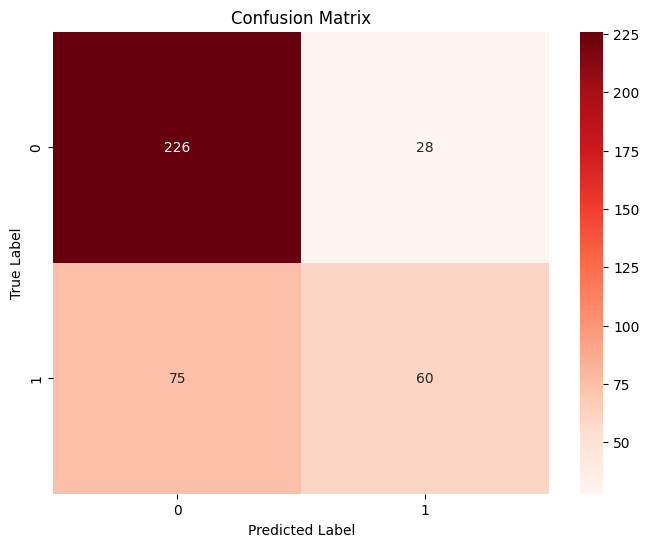

Accuracy: 0.7352185089974294
F1 Score (Class 1): 0.538116591928251
Recall (Macro): 0.6671041119860017
Precision (Macro): 0.7163243733011175


In [4]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-206')
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_1 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])
df_merged_1 = pd.concat([df_dev, df_predictions_1], axis=1)
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_1['label']
predicted_labels = df_merged_1['predicted_label']
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_1.to_csv('MiniLM_task5_predictions_002_epoch_1.csv', index=False)

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

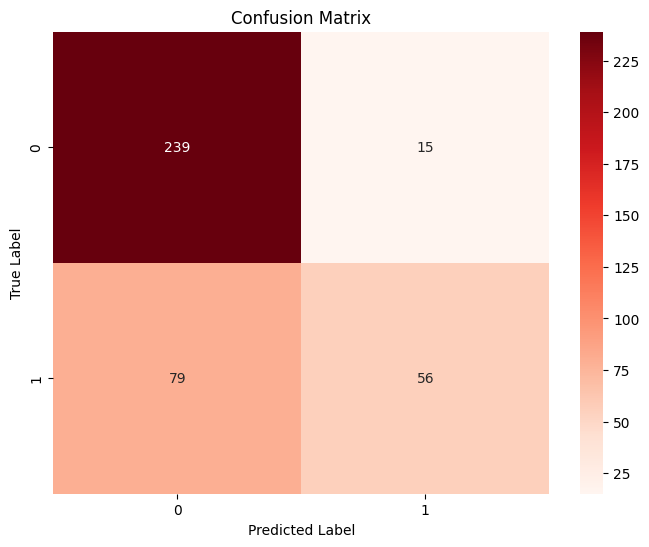

Accuracy: 0.7583547557840618
F1 Score (Class 1): 0.5436893203883494
Recall (Macro): 0.6778798483522893
Precision (Macro): 0.7701523607051112


In [5]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-412')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_2 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_2 = pd.concat([df_dev, df_predictions_2], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_2['label']                                                                                               # HERE
predicted_labels = df_merged_2['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_2.to_csv('MiniLM_task5_predictions_002_epoch_2.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

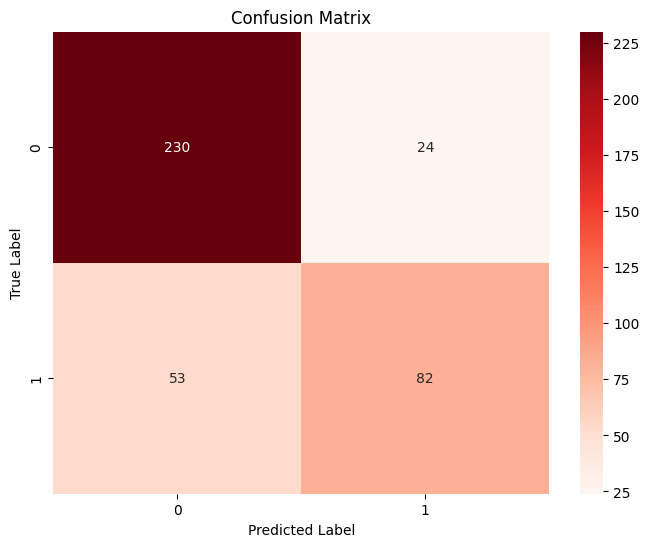

Accuracy: 0.8020565552699229
F1 Score (Class 1): 0.6804979253112033
Recall (Macro): 0.7564596092155147
Precision (Macro): 0.7931528768584573


In [6]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-618')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_3 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_3 = pd.concat([df_dev, df_predictions_3], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_3['label']                                                                                               # HERE
predicted_labels = df_merged_3['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_3.to_csv('MiniLM_task5_predictions_002_epoch_3.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

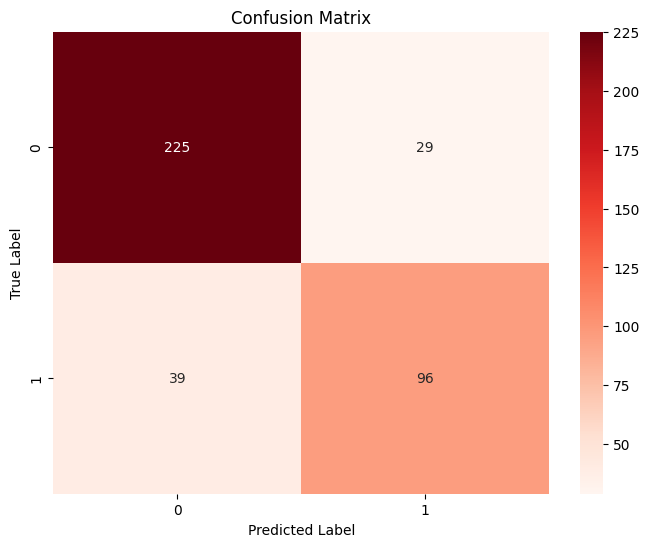

Accuracy: 0.8251928020565553
F1 Score (Class 1): 0.7384615384615385
Recall (Macro): 0.7984689413823272
Precision (Macro): 0.8101363636363637


In [7]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-824')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_4 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_4 = pd.concat([df_dev, df_predictions_4], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_4['label']                                                                                               # HERE
predicted_labels = df_merged_4['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_4.to_csv('MiniLM_task5_predictions_002_epoch_4.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

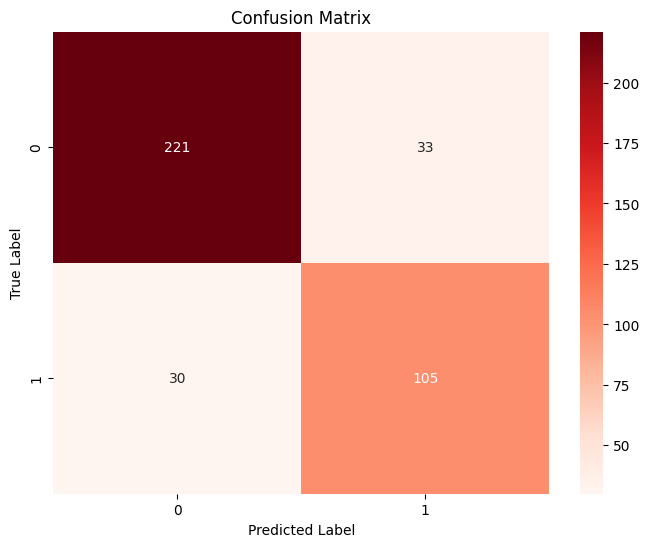

Accuracy: 0.8380462724935732
F1 Score (Class 1): 0.7692307692307693
Recall (Macro): 0.8239282589676291
Precision (Macro): 0.8206738264333968


In [8]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-1030')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_5 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_5 = pd.concat([df_dev, df_predictions_5], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_5['label']                                                                                               # HERE
predicted_labels = df_merged_5['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_5.to_csv('MiniLM_task5_predictions_002_epoch_5.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

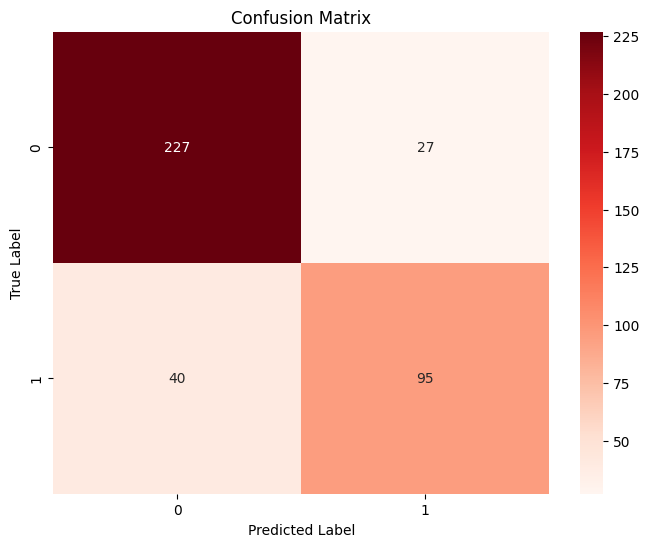

Accuracy: 0.8277634961439588
F1 Score (Class 1): 0.7392996108949416
Recall (Macro): 0.7987022455526392
Precision (Macro): 0.8144378952538834


In [9]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-1236')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_6 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_6 = pd.concat([df_dev, df_predictions_6], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_6['label']                                                                                               # HERE
predicted_labels = df_merged_6['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_6.to_csv('MiniLM_task5_predictions_002_epoch_6.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

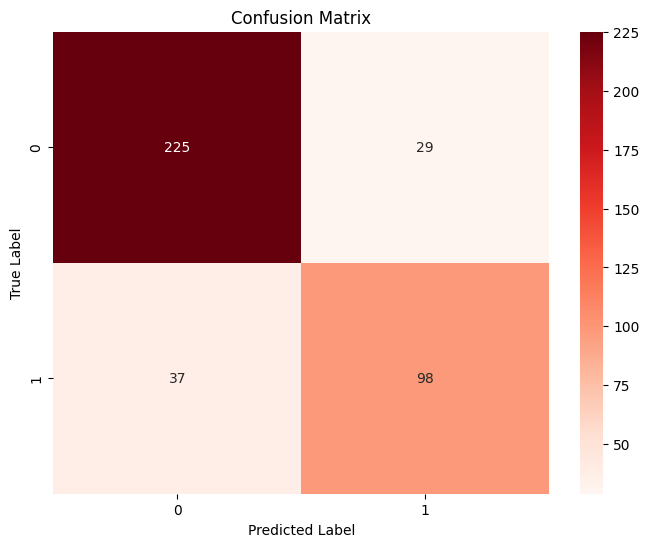

Accuracy: 0.8303341902313625
F1 Score (Class 1): 0.7480916030534351
Recall (Macro): 0.8058763487897347
Precision (Macro): 0.8152160846306425


In [10]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-1442')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_7 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_7 = pd.concat([df_dev, df_predictions_7], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_7['label']                                                                                               # HERE
predicted_labels = df_merged_7['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_7.to_csv('MiniLM_task5_predictions_002_epoch_7.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

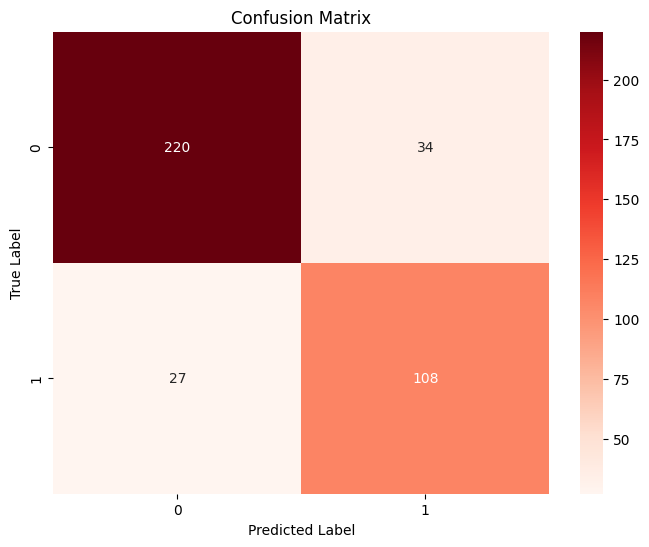

Accuracy: 0.8431876606683805
F1 Score (Class 1): 0.779783393501805
Recall (Macro): 0.8330708661417323
Precision (Macro): 0.8256258196955009


In [11]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-1648')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_8 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_8 = pd.concat([df_dev, df_predictions_8], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_8['label']                                                                                               # HERE
predicted_labels = df_merged_8['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_8.to_csv('MiniLM_task5_predictions_002_epoch_8.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

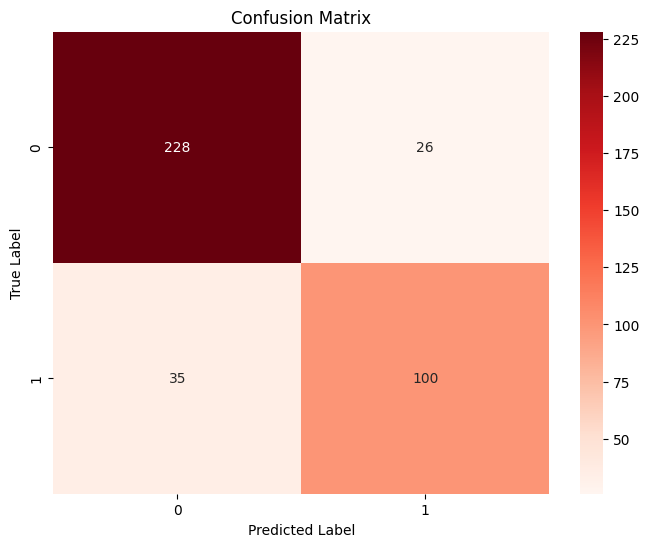

Accuracy: 0.8431876606683805
F1 Score (Class 1): 0.7662835249042144
Recall (Macro): 0.8191892680081656
Precision (Macro): 0.8302854728710242


In [12]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-1854')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_9 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_9 = pd.concat([df_dev, df_predictions_9], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_9['label']                                                                                               # HERE
predicted_labels = df_merged_9['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_9.to_csv('MiniLM_task5_predictions_002_epoch_9.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

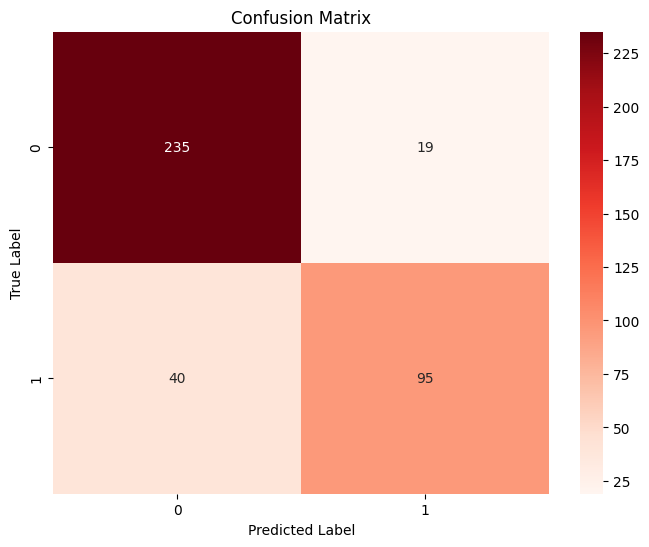

Accuracy: 0.8483290488431876
F1 Score (Class 1): 0.7630522088353413
Recall (Macro): 0.8144502770487023
Precision (Macro): 0.843939393939394


In [13]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-2060')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_10 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_10 = pd.concat([df_dev, df_predictions_10], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_10['label']                                                                                               # HERE
predicted_labels = df_merged_10['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_10.to_csv('MiniLM_task5_predictions_002_epoch_10.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

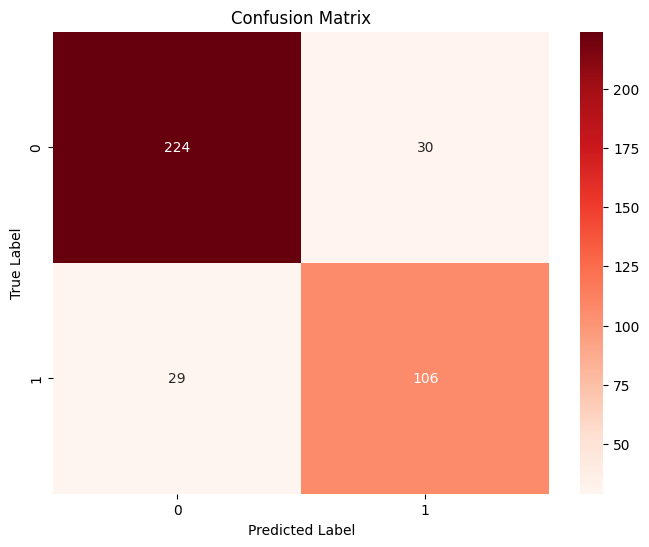

Accuracy: 0.8483290488431876
F1 Score (Class 1): 0.7822878228782287
Recall (Macro): 0.8335374744823564
Precision (Macro): 0.8323936293885144


In [14]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-2266')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_11 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_11 = pd.concat([df_dev, df_predictions_11], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_11['label']                                                                                               # HERE
predicted_labels = df_merged_11['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_11.to_csv('MiniLM_task5_predictions_002_epoch_11.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

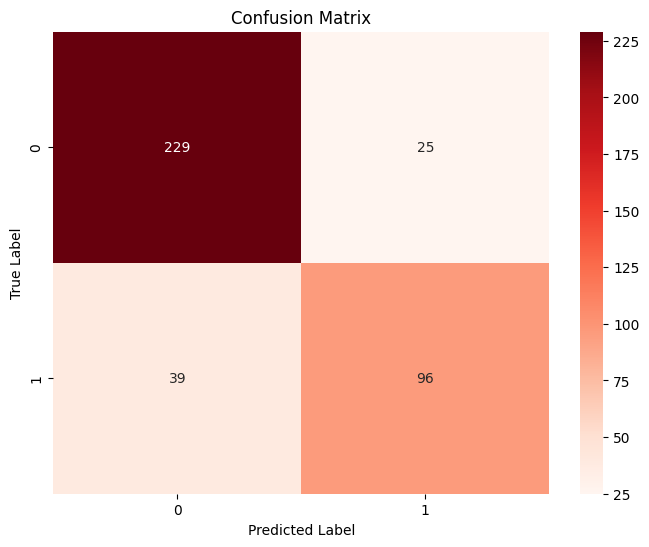

Accuracy: 0.8354755784061697
F1 Score (Class 1): 0.75
Recall (Macro): 0.8063429571303586
Precision (Macro): 0.8239330208461824


In [15]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-2472')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_12 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_12 = pd.concat([df_dev, df_predictions_12], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_12['label']                                                                                               # HERE
predicted_labels = df_merged_12['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_12.to_csv('MiniLM_task5_predictions_002_epoch_12.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

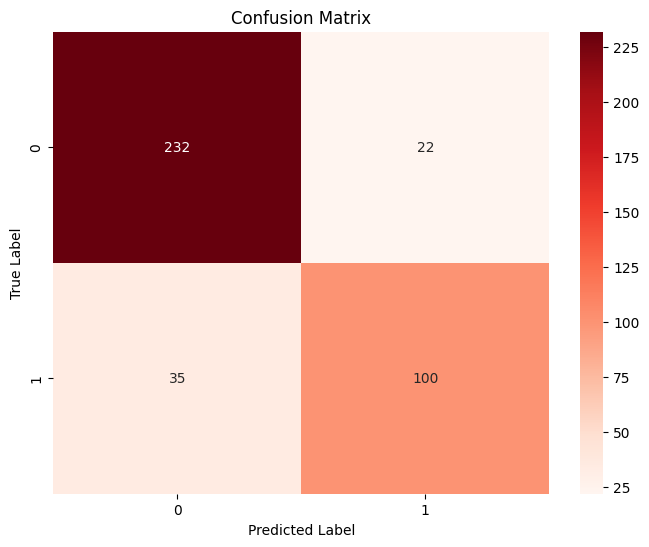

Accuracy: 0.8534704370179949
F1 Score (Class 1): 0.7782101167315174
Recall (Macro): 0.8270632837561971
Precision (Macro): 0.8442929944127218


In [16]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-2678')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_13 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_13 = pd.concat([df_dev, df_predictions_13], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_13['label']                                                                                               # HERE
predicted_labels = df_merged_13['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_13.to_csv('MiniLM_task5_predictions_002_epoch_13.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

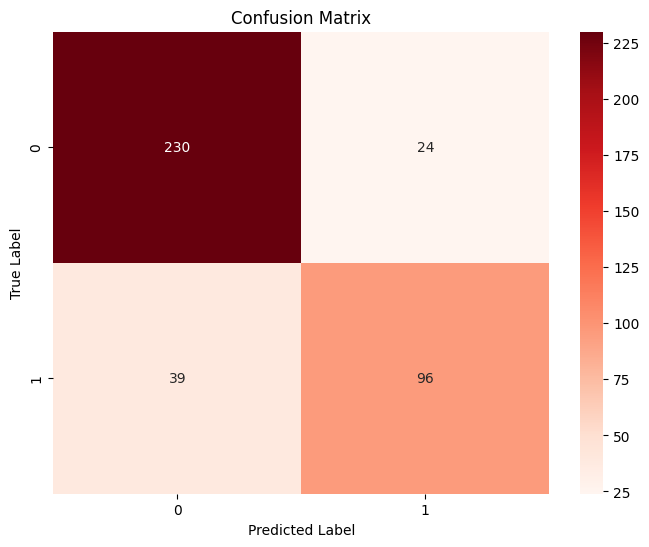

Accuracy: 0.8380462724935732
F1 Score (Class 1): 0.7529411764705882
Recall (Macro): 0.8083114610673665
Precision (Macro): 0.8275092936802975


In [17]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-2884')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_14 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_14 = pd.concat([df_dev, df_predictions_14], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_14['label']                                                                                               # HERE
predicted_labels = df_merged_14['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_14.to_csv('MiniLM_task5_predictions_002_epoch_14.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

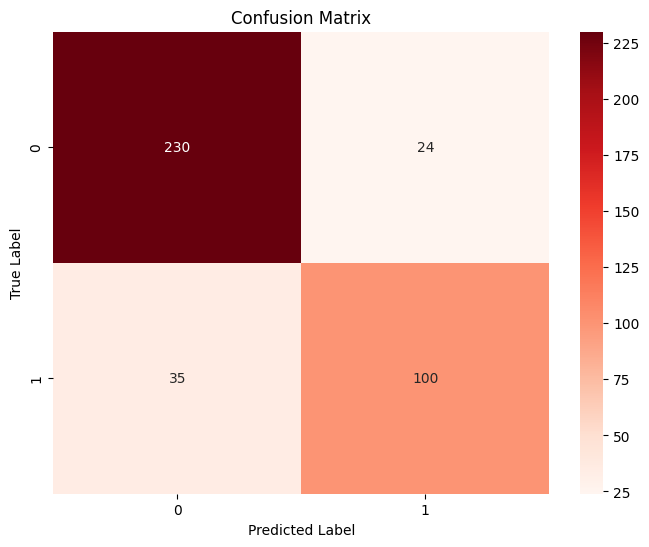

Accuracy: 0.8483290488431876
F1 Score (Class 1): 0.7722007722007722
Recall (Macro): 0.8231262758821813
Precision (Macro): 0.8371880706025563


In [18]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-3090')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_15 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_15 = pd.concat([df_dev, df_predictions_15], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_15['label']                                                                                               # HERE
predicted_labels = df_merged_15['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_15.to_csv('MiniLM_task5_predictions_002_epoch_15.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

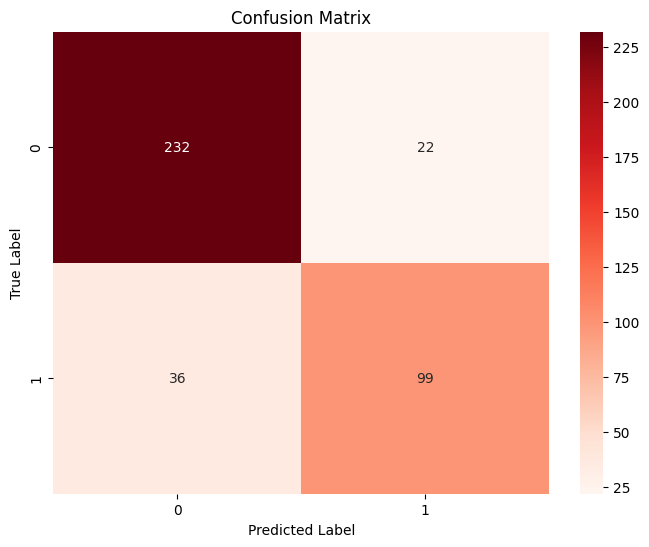

Accuracy: 0.8508997429305912
F1 Score (Class 1): 0.7734375
Recall (Macro): 0.8233595800524934
Precision (Macro): 0.8419267299864315


In [19]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-3296')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_16 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_16 = pd.concat([df_dev, df_predictions_16], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_16['label']                                                                                               # HERE
predicted_labels = df_merged_16['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_16.to_csv('MiniLM_task5_predictions_002_epoch_16.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

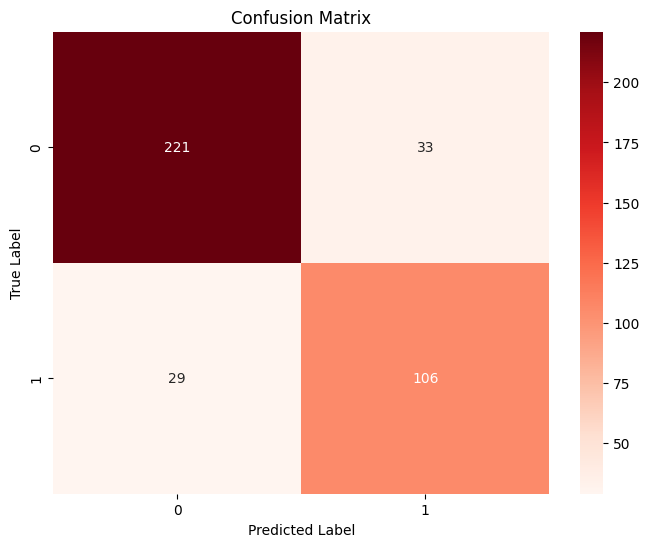

Accuracy: 0.8406169665809768
F1 Score (Class 1): 0.7737226277372262
Recall (Macro): 0.8276319626713328
Precision (Macro): 0.823294964028777


In [20]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-3502')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_17 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_17 = pd.concat([df_dev, df_predictions_17], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_17['label']                                                                                               # HERE
predicted_labels = df_merged_17['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_17.to_csv('MiniLM_task5_predictions_002_epoch_17.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

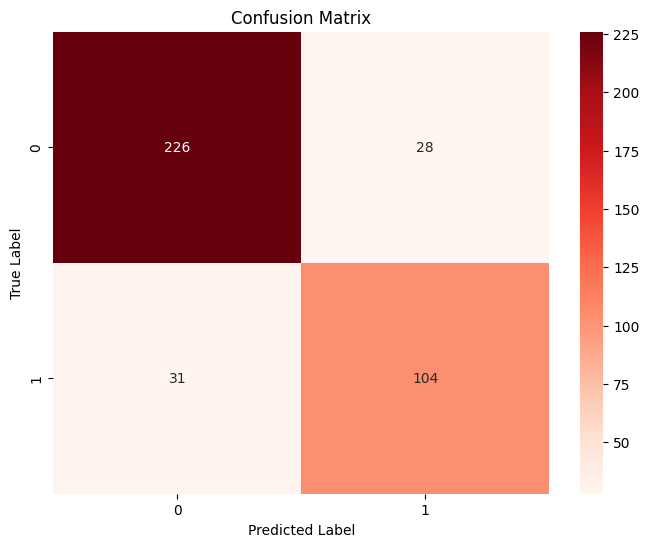

Accuracy: 0.8483290488431876
F1 Score (Class 1): 0.7790262172284643
Recall (Macro): 0.8300670749489647
Precision (Macro): 0.8336281098927013


In [21]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-3708')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_18 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_18 = pd.concat([df_dev, df_predictions_18], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_18['label']                                                                                               # HERE
predicted_labels = df_merged_18['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_18.to_csv('MiniLM_task5_predictions_002_epoch_18.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

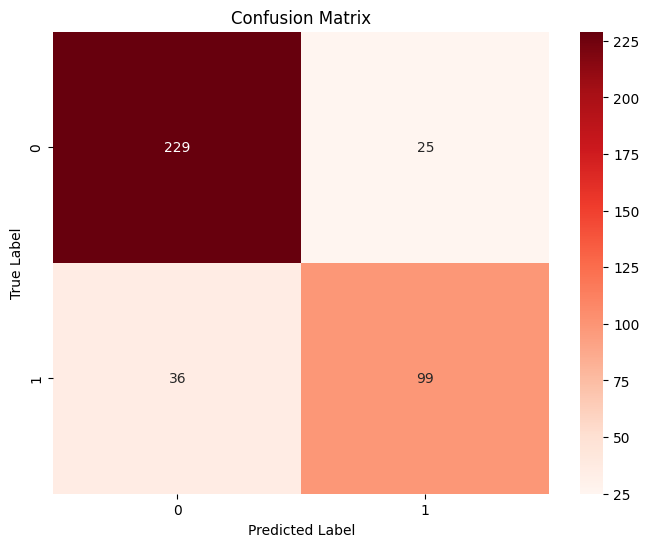

Accuracy: 0.8431876606683805
F1 Score (Class 1): 0.7644787644787644
Recall (Macro): 0.8174540682414697
Precision (Macro): 0.83126902008521


In [22]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-3914')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_19 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_19 = pd.concat([df_dev, df_predictions_19], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_19['label']                                                                                               # HERE
predicted_labels = df_merged_19['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_19.to_csv('MiniLM_task5_predictions_002_epoch_19.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

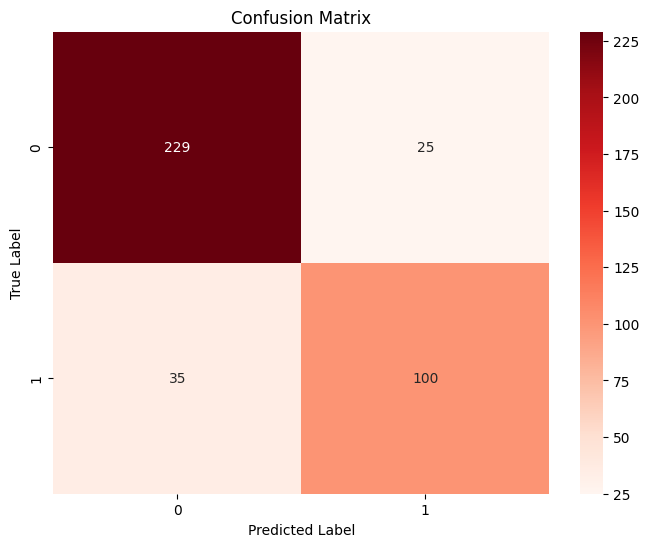

Accuracy: 0.8457583547557841
F1 Score (Class 1): 0.7692307692307692
Recall (Macro): 0.8211577719451735
Precision (Macro): 0.8337121212121212


In [23]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-4120')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_20 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_20 = pd.concat([df_dev, df_predictions_20], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_20['label']                                                                                               # HERE
predicted_labels = df_merged_20['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_20.to_csv('MiniLM_task5_predictions_002_epoch_20.csv', index=False)                                                          # HERE  # HERE